In [3]:
import binance
import pandas as pd
from ipywidgets import widgets
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import time
import datetime
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random


X_columns = ["gap", "overall_gap", "where_in_gap", "numTrades"] # columns we will keep for 1st preprocessing steps
#X_columns_final = ["gap", "overall_gap", "where_in_gap", "numTrades","buyer_is_maker"]# columns we will keep for last preprocessing steps (after trades have been added)
X_columns_final = ["gap","numTrades","buyer_is_maker"]# columns we will keep for last preprocessing steps (after trades have been added)
y_columns = ['is_l100','is_l1000', 'is_h100','is_h1000'] # our Y columns
time_step= 100 # how many time units used to explain each output

check_steps = [10,100,1000,10000,50000,100000,150000] # used as monitoring steps for progress during long calculation processes

start_point = '1544844000000' # timestamp (in ms) to start from: Dec 15th 2018, when we started data collection from
current_point = 1556184840000 # current time: Apr 25th 11:34 am, when I started traininf the LSTM network

low_limit = .0001 # values to ignore in your balance (Not Used yet, will be for further integration with Binance Portofolio)

btcusd = 'BTCUSDT'# the exchange we're using as BTC valuation in USD


# depth of history for min, hrs, day, month when we call Binance APIs
depth_min = '1000'
depth_hrs = '120'
depth_day = '60'
depth_mth = '5'

keys = pd.read_csv("binancekey.csv")# your APIs keys and Secret must be stored in a csv file on root directory.
api_key = keys.loc[0,"api_key"]
api_secret = keys.loc[0,"api_secret"]


### Reusable function for time conversion

# converts time stamp to standard date/time
def clean_date(histo, value):
    histo["closeTime"] = histo["closeTime"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    histo["openTime"] = histo["openTime"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    histo["xch"] = value
    return histo

# collects history of valuations by minutes/day/hours/month. 
def build_histo(minutes, hours, days, months):
    Hminutes = clean_date(pd.DataFrame(binance.klines(btcusd,minutes,limit = depth_min)),btcusd)
    Hhours = clean_date(pd.DataFrame(binance.klines(btcusd,hours,limit = depth_hrs)), btcusd)
    Hdays = clean_date(pd.DataFrame(binance.klines(btcusd,days,limit = depth_day)), btcusd)
    Hmonths = clean_date(pd.DataFrame(binance.klines(btcusd,months,limit = depth_mth)), btcusd)
    return Hminutes, Hhours, Hdays, Hmonths

<h1>In previous steps we collected all data in small chunks (to be kind to Binance API), now let's rebuild 1 complete files from various archives of stocks values

In [ ]:
files = os.listdir("data binance/archives stocks/") # where your many small files are
files.sort()

data = pd.DataFrame()
for items in files: 
    temp = pd.read_csv('data binance/archives stocks/' + items, index_col = 0)
    data = data.append(temp, ignore_index = True)
data = clean_date(data,btcusd)
data.to_csv("data binance/klines_all.csv")

# reload all Klines from file and reindex them (they may have gotten in wrong sequence when compounding small files together)
data = pd.read_csv('data binance/klines_all.csv', index_col = 0)
data = data.sort_values("openTime")
data = data.reindex()

In [ ]:
# Same process with trades information
rebuild 1 complete files from various archives of trades
files = os.listdir("data binance/archives trades")
files.sort()

data = pd.DataFrame()
for items in files: 
    temp = pd.read_csv('data binance/archives trades/' + items, index_col = 0)
    data = data.append(temp, ignore_index = True)
    print(items)
#data["openTime"] = data["T"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
data = data.sort_values("T")
data = data.reindex()
data.to_csv("data binance/trades_all.csv")
# reload all Klines from file
#data = pd.read_csv('trades_all.csv', index_col = 0)


 <h1>Let's now enrich our datasets. We will calculate for each line what is the highest and lowest value of the coming 100 and 1000 records. This will help us encode Y variables in next steps. At that stage I chose to keep both 100 and 1000 minutes approach since both may turn to be useful in future.</h2>

In [ ]:
for i in range(0,len(data) - 1000):
    
    data.loc[i,"lowest_of_100"] = data.loc[i:i+99,"low"].min() # capture lowest of next 100
    data.loc[i,"lowest_of_1000"] = data.loc[i:i+999,"low"].min() # capture lowest of next 1000

    data.loc[i,"highest_of_100"] = data.loc[i:i+99,"high"].max() # record is highest of next 100
    data.loc[i,"highest_of_1000"] = data.loc[i:i+999,"high"].max() # record is highest of next 1000

# progress monitoring: this allows to control how far processing has gone in the file length          
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.fromtimestamp(time.time()))     
        
data.to_csv("data binance/with_lowest_of_10.csv")    # make regular backup to flat file to avoid reprocessing all in case of problem

In [ ]:
data = pd.read_csv("data binance/with_lowest_of_10.csv", index_col = 0)

 <h1> Let's optimize the input variable  </h1>

 
* instead of a open/close value, let's rather collect the *gap* between open and close. This will give us a better trend, and be more abstract to context that a stock value
* let's capture the overal gap between highest and lowest point, as volatility can be a sign of trend change
* and let's capture where the closing is situated in this overal gap: rather on top? or on bottom?


In [ ]:
data["gap"] = data["close"] - data["open"]
data["overall_gap"] = data["high"] - data["low"]
data["where_in_gap"] = data["close"] - (data["high"] + data["low"])/2

 <h1>Let's now encode our "Y" variables </h1>

* is it the highest point of next 100 minutes?
* is it the highest point of next 1000 minutes?
* is it the lowest point of next 100 minutes?
* is it the lowest point of next 1000 minutes?

In [ ]:
data.to_csv("with_lowest_of_10_v2.csv") 

In [ ]:
data = pd.read_csv("with_lowest_of_10_v2.csv", index_col = 0)

data["is_l100"] = data.lowest_of_100 == data.low
data["is_l1000"] = data.lowest_of_1000 == data.low

data["is_h100"] = data.highest_of_100 == data.high
data["is_h1000"] = data.highest_of_1000 == data.high

data["is_l100"] = [int(r) for r in data["is_l100"]]
data["is_l1000"] = [int(r) for r in data["is_l1000"]]

data["is_h100"] = [int(r) for r in data["is_h100"]]
data["is_h1000"] = [int(r) for r in data["is_h1000"]]

data.to_csv("with_lowest_of_10_v2.csv") 


<h1>GET TRADE INFO</H1>



In [ ]:
trades = pd.read_csv("data binance/Trades_all.csv", index_col=0)
data = pd.read_csv("data binance/with_lowest_of_10_v2.csv", index_col = 0)

In [ ]:
trades.index = trades["T"].apply(lambda x: datetime.datetime.fromtimestamp(x/1000)) # convert timestamp in std dateTime

test1 = trades.resample("1min",how="count").rename({"T":"openTime"}, axis=1) # reaggregate trade counts per minute
test1["openTime"] = test1.index
test2 = trades.resample("1min",how="sum").rename({"T":"openTime"}, axis=1)# reaggregate trade count for those which are "Buyer is the maker", per minute
test2["openTime"] = test2.index

for i in range(len(data)):
    tstp = data.loc[i,"openTime"]
    try:
        data.loc[i,"buyer_is_maker"] = test2.loc[tstp,"m"] / test1.loc[tstp,"m"] # for each minute of the dataset, enrich wiht the proportion of trades where buyer is maker
    except:
        data.loc[i,"buyer_is_maker"] = 0
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.now())         


In [ ]:
data.sort_values("buyer_is_maker")

In [ ]:
data.to_csv("data binance/with_lowest_of_10_and_trades.csv") 

<H1> FILE OUTPUT </H1>

* this is where we produce the file that will feed the neural network 
* The last 15% of the dataset are saved for further testing. 
* from the remaining 85%, we extract all records where y = 1, and provide and random sample of records where y = 0. This way, we balance our dataset. This is important because the proportion of y=1 is below 10%,  which could induce a distortion in the training of network.

In [4]:
data = pd.read_csv("data binance/with_lowest_of_10_and_trades.csv", index_col = 0)


In [5]:
train_lim = int(len(data)*0.7) # training set length
val_lim = int(len(data)*0.85)  # validation set length

min_max_scaler = MinMaxScaler() # data are normalized
fitted = min_max_scaler.fit(data.loc[:val_lim,X_columns_final])# normalization is fitted to train/val data only
data[X_columns_final] = fitted.transform(data[X_columns_final])# tehn applied to the whole dataset

data_temp = data # store temporarily 'data
data = data.loc[time_step:val_lim,:] # skim data to build Train and Val, keep Test range untouched

index_100 = []
index_100.extend(data[data.is_l100 + data.is_h100 > 0].index) # collect all records with y = 1
index_100.extend(data[data.is_l100 + data.is_h100 == 0].sample(len(index_100)).index) # collect a subset of records where y = 0
index_100.sort()

index_1000 = []
index_1000.extend(data[data.is_l1000 + data.is_h1000 > 0].index)
index_1000.extend(data[data.is_l1000 + data.is_h1000 == 0].sample(len(index_1000)).index)
index_1000.sort()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
data = data_temp #recover complete dataset

t_f_100 = [(r in index_100) for r in data.index]  # build the range of items for train/val datasets
t_f_1000 = [(r in index_1000) for r in data.index]

data_100 = data[t_f_100] # build the train/val dataset
data_1000 = data[t_f_1000]
data_test = data[val_lim:len(data)-1000] # build the test dataset

In [7]:
# LSTM requires that each record carries it's history. We define depth of history wiht "time_step". This is done for both train/val sets (100 and 1000), and for the test file

history = []
for i in index_1000: 
    history.append(data.loc[i+1-time_step:i,X_columns_final].values) 
data_1000.loc[:,"history"] = history

history = []
for i in index_100: 
    history.append(data.loc[i+1-time_step:i,X_columns_final].values) 
data_100.loc[:,"history"] = history

history = []
for i in data_test.index: 
    history.append(data.loc[i+1-time_step:i,X_columns_final].values) 
data_test.loc[:,"history"] = history
data_test.to_csv("traintest/test_data_backup.csv")

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
def to_train_file(data, y_col,pref):                
                
    X = data["history"] 
    y = data[y_col]
    
    X = np.array([a for a in X])
    y = np.array(y.values)
    
    train_lim = int(len(data)*0.85) # training set length
 
    X_train = X[0:train_lim]
    X_val = X[train_lim:]
    y_train = y[0:train_lim]
    y_val =  y[train_lim:]
        
    np.save(pref+'x_train',X_train)
    np.save(pref+'x_val',X_val)
    np.save(pref+'y_train',y_train)
    np.save(pref+'y_val',y_val)
#    return X_train

def to_test_file(data, y_col,pref):
    X = data["history"] 
    y = data[y_col]

    X = np.array([a for a in X])
    y = np.array(y.values)
        
    np.save(pref+'x_test',X)
    np.save(pref+'y_test',y)

to_train_file(data_100,["is_l100","is_h100"],'traintest/100_')
to_train_file(data_1000,["is_l1000","is_h1000"],'traintest/1000_')
to_test_file(data_test,["is_l100","is_h100"],'traintest/100_')
to_test_file(data_test,["is_l1000","is_h1000"],'traintest/1000_')

array([0.67613412, 0.0112805 , 0.68210325, 0.01624519, 0.45942572])

<h1> Analysis of data distribution and variables behavior </h1>
* this step intends to deep dive into the data set befor training it
* trying to understand if the approach makes sense and if profit could ultimately come if we guess properly tops and bottoms


In [ ]:
data = pd.read_csv("data binance/with_lowest_of_10_v2.csv", index_col = 0)
data=data.loc[:,["gap","overall_gap","where_in_gap","numTrades","is_l100","is_h100"]]
dl100y =data[data["is_l100"]==1].describe()
dl100n = data[data["is_l100"]==0].describe()
dh100y = data[data["is_h100"]==1].describe()
dh100n = data[data["is_h100"]==0].describe()
result=pd.DataFrame()
for columns in X_columns:
    result["is Low100"] = dl100y[columns] 
    result["is not Low100"] = dl100n[columns]
    result["is High 100"] = dh100y[columns]
    result["is not High100"] = dh100n[columns]
    print("analysis of {}: \n".format(columns),"\n",result,"\n")

sns.boxplot(x=data['is_l100'], y=data.gap[data["gap"]**2 < 10])
plt.show()
sns.boxplot(x=data['is_h100'], y=data.gap[data["gap"]**2 < 10])
plt.show()

print("is L100 \n",data[data["is_l100"]==1].describe(), "is not L100 \n",data[data["is_l100"]==0].describe())
print("is H100 \n",data[data["is_h100"]==1].describe(), "is not H100 \n",data[data["is_h100"]==0].describe())

print("behavior of volume for low spot \n")
sns.boxplot(x=data['is_l100'], y=data["volume"])
plt.show()

print("behavior of volume for high spot \n")
sns.boxplot(x=data['is_h100'], y=data["volume"])
plt.show()

print("behavior of buyer_is_maker for low spot \n")
sns.boxplot(x=data["is_l100"],y=data.loc[data["buyer_is_maker"] > .4,"buyer_is_maker"])
plt.show()

print("behavior of buyer is maker for high spot \n")
sns.boxplot(x=data["is_h100"],y=data.loc[data["buyer_is_maker"] > .4,"buyer_is_maker"])
plt.show()


<h1> How much would we have made if we had been able to spot the best 10 trades?
    

In [10]:
data = pd.read_csv("data binance/with_lowest_of_10_v2.csv", index_col = 0)

In [ ]:
look_for = 'buy'
buy_price = .0
for i in range(len(data)-1):
    if look_for == 'buy' and data.loc[i,"is_l100"]==1:
        buy_price = data.loc[i,"low"]
        buy_time = i
        look_for = "sell"
    elif look_for == 'sell' and data.loc[i,"is_h100"]==1:
        data.loc[i,"profit"] = 0.99*data.loc[i,"high"] - buy_price # a penalty of 1% is applied to represent trade fees applied by excahnge  platform
        data.loc[i,"immo_time"] = i - buy_time
        look_for = "buy"
    if i in check_steps:
        print("over {}".format(i),datetime.datetime.now())     

**Profit distribution** 

* zooming on 25/75 quartiles (1st graph) shows that half of transactions hits a profits from -20 to +20
* but the global picture (second graph) shows that thanks to occasional exceptional gains, the average gain is positive
* this is how we get a median of -4 along with a mean of 9.95
* we also notice the the average investment duration is 118 minutes between buy and sell

zoom on profit obtained:
            profit   immo_time
count  879.000000  879.000000
mean     9.953841  118.982935
std     48.600023   82.658288
min    -35.277400    1.000000
25%    -16.047250   57.000000
50%     -4.180000  103.000000
75%     18.701350  160.500000
max    652.485600  481.000000

 median = -4.180000000000291 and mean = 9.95384141069391


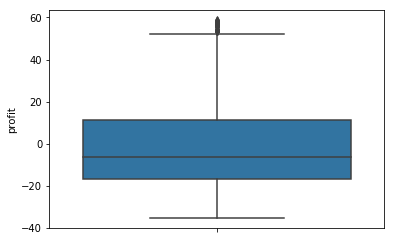

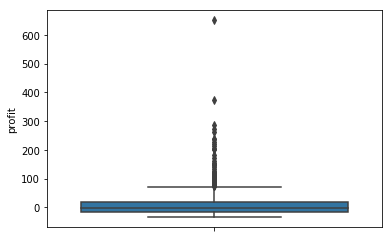

In [12]:
print("zoom on profit obtained:\n", data[["profit","immo_time"]].describe())
sns.boxplot(y = data.profit[data["profit"]<60])
print("\n median = {} and mean = {}".format(data["profit"].median(),data["profit"].mean() ))
plt.show()
sns.boxplot(y = data["profit"])



* Focusing on the top trades (ranked by descending profit) we can also conclude that being selective is key. Most trades will generate a profit close to 0 or even negative, mostly because of trading fees. 
* however, if we manage to trigger trades only on best situations, we can be largely positive.
* the top 20 trades of the last 5 months alone would have generated a nearly 100% profit.

In [13]:
n_trades = 20
top_trades = round(data.sort_values("profit", ascending=False).head(n_trades)[["immo_time","profit"]].describe(),2)
achieved_profit = top_trades["profit"]["mean"]*n_trades
mkt_g = round(data.loc[len(data)-1,"close"] - data.loc[0,"close"],2)

print("total gain realised with {} trades:{}".format(n_trades,achieved_profit))
print("natural growth of market: {} - {} = {}".format(data.loc[0,"close"],data.loc[len(data)-1,"close"],achieved_profit))
print("{} best trades outperforms market: {}%".format(n_trades,round(achieved_profit / mkt_g * 100),2))




total gain realised with 20 trades:4708.8
natural growth of market: 3251.54 - 5403.35 = 4708.8
20 best trades outperforms market: 219.0%


* Let's be more realistic and assume that we get the top 20 and worst 20 of the trades
* the trades still outperform the market 

In [14]:
n_trades = 20
top_trades = round(data.sort_values("profit", ascending=False).head(n_trades)[["immo_time","profit"]].describe(),2)
worst_trades = round(data.sort_values("profit", ascending=True).head(n_trades)[["immo_time","profit"]].describe(),2)

achieved_profit = top_trades["profit"]["mean"]*n_trades + worst_trades["profit"]["mean"]*n_trades
mkt_g = round(data.loc[len(data)-1,"close"] - data.loc[0,"close"],2)

print("total gain realised with {} best and worst trades:{}".format(n_trades,achieved_profit))
print("natural growth of market: {} - {} = {}".format(data.loc[0,"close"],data.loc[len(data)-1,"close"],achieved_profit))
print("{} best trades outperforms market: {}%".format(n_trades,round(achieved_profit / mkt_g * 100),2))




total gain realised with 20 best and worst trades:4098.400000000001
natural growth of market: 3251.54 - 5403.35 = 4098.400000000001
20 best trades outperforms market: 190.0%
